- **Tarea del backlog:** https://github.com/UCM-GIDIA-PD1/c2425-R4/issues/26.
- **Propósito del código:** Transformaciones y primer modelo regresión logística.  
- **Autor(es):** Francisco Pastor.  
- **Descripción y uso:** Ejecutar para ver resultado de modelo regresión logística en P2.
- **Estado actual:** Importante revisión ya que presenta un Accuracy del 49%.


# REGRESIÓN LOGÍSTICA

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import os
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
#Leo los df divididos en orden cronológico de forma que los resultados sean lo más reales posibles
ruta_train =  os.path.join("..","..","..", "data", "processed","train.parquet")
df_train= pd.read_parquet(ruta_train)
df_train.head()

,DATE,Peleador_A,Peleador_B,WINNER,KD_A,KD_B,SIG_STR_A,SIG_STR_B,TD_PORC_A,TD_PORC_B,...,Derrotas_Sub_A,Derrotas_Sub_B,Derrotas_Decision_A,Derrotas_Decision_B,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF
0,2000-06-09,Kevin Randleman,Pedro Rizzo,False,0.0,0.8,0.279,0.315,0.770,0.000,...,0.0,0.0,0.8,0.0,-0.8,-0.036,0.615385,1.0,0.0,526.0
1,2000-09-22,Jeremy Horn,Eugene Jackson,False,0.0,0.5,0.696,0.550,0.084,0.000,...,0.0,0.5,0.0,0.0,-0.5,0.146,0.250000,0.4,0.0,3.3
2,2001-02-23,Tito Ortiz,Evan Tanner,False,0.3,0.0,0.552,0.741,0.874,1.000,...,0.0,0.0,0.0,0.0,0.3,-0.189,0.178571,-0.1,0.0,458.1
3,2001-05-04,Chuck Liddell,Kevin Randleman,False,0.0,0.0,0.508,0.532,0.000,0.758,...,1.0,0.0,0.0,1.0,0.0,-0.024,-0.518519,-1.5,0.2,-455.0
4,2001-06-29,Pat Miletich,Shonie Carter,False,0.0,1.0,0.451,0.521,0.500,0.646,...,0.5,0.0,0.0,0.0,-1.0,-0.070,0.037945,0.8,-1.2,-137.3


In [11]:
ruta_test =  os.path.join("..","..","..", "data", "processed","test.parquet")
df_test= pd.read_parquet(ruta_test)
df_test.head()

,DATE,Peleador_A,Peleador_B,WINNER,KD_A,KD_B,SIG_STR_A,SIG_STR_B,TD_PORC_A,TD_PORC_B,...,Derrotas_Sub_A,Derrotas_Sub_B,Derrotas_Decision_A,Derrotas_Decision_B,KD_DIFF,SIG_STR_DIFF,TD_DIFF,SUB_ATT_DIFF,REV_DIFF,CTRL_DIFF
0,2023-04-22,Rani Yahya,Montel Jackson,True,0.0,2.1,0.569,0.513,0.415,0.240,...,0.0,0.0,5.0,2.0,-2.1,0.056,0.047222,0.5,0.7,140.0
1,2023-04-22,Jeremiah Wells,Matthew Semelsberger,False,0.7,1.8,0.529,0.382,0.060,0.800,...,0.0,0.0,0.0,1.8,-1.1,0.147,-0.403226,0.3,0.0,-111.5
2,2023-04-29,Caio Borralho,Michal Oleksiejczuk,False,0.0,0.6,0.565,0.510,0.690,0.100,...,0.0,2.0,0.0,1.0,-0.6,0.055,0.370656,1.0,1.2,414.4
3,2023-04-29,Song Yadong,Ricky Simon,False,0.5,0.8,0.379,0.595,0.500,0.407,...,0.0,0.0,1.0,1.0,-0.3,-0.216,0.150000,-0.7,0.0,-244.9
4,2023-04-29,Rodolfo Vieira,Cody Brundage,False,0.0,0.3,0.528,0.214,0.305,0.700,...,1.0,0.0,0.5,1.0,-0.3,0.314,-0.393102,0.1,0.0,62.6


In [12]:
X_train = df_train.drop(columns=["DATE","Peleador_A","Peleador_B","WINNER"])
y_train = df_train["WINNER"]
y_train.value_counts(normalize=True)

WINNER
False    0.618167
True     0.381833
Name: proportion, dtype: float64

In [13]:
X_test = df_test.drop(columns=["DATE","Peleador_A","Peleador_B","WINNER"])
y_test = df_test["WINNER"]
y_test.value_counts(normalize=True)

WINNER
False    0.551724
True     0.448276
Name: proportion, dtype: float64

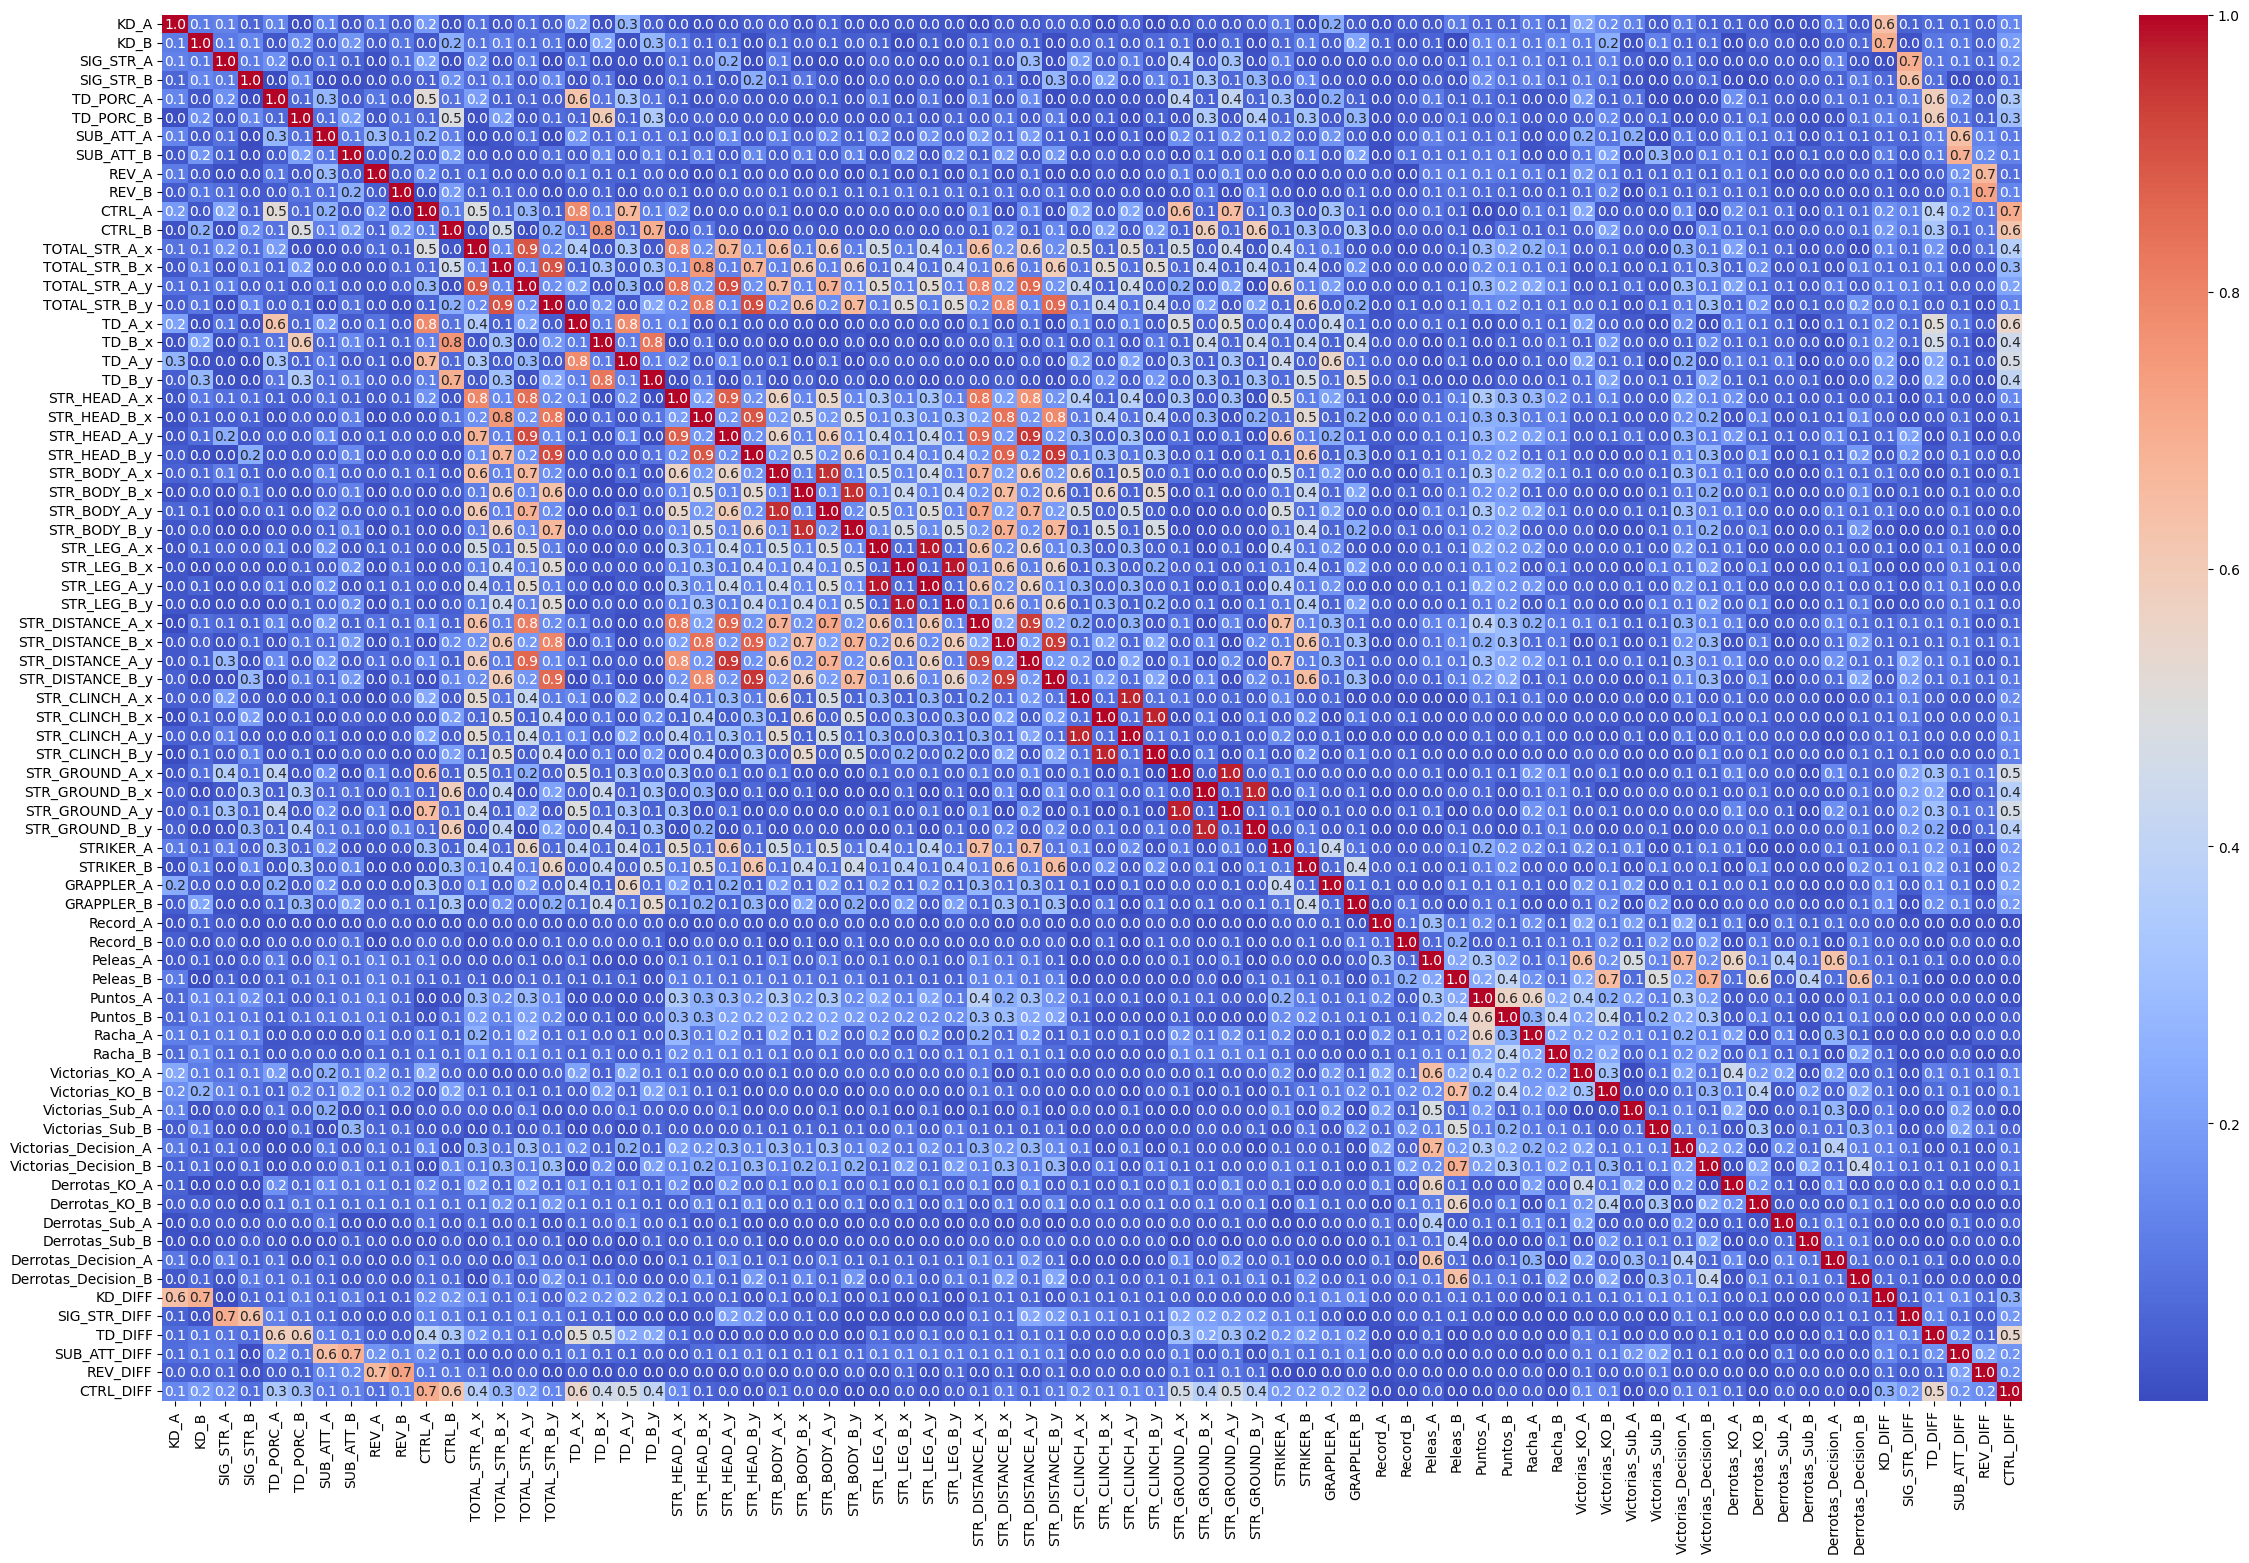

In [14]:
plt.figure(figsize=(30, 18))
sns.heatmap(X_train.corr().abs(), annot=True, cmap="coolwarm", fmt=".1f")
plt.show()

In [15]:
# Calculo la matriz de correlación con spearman ya que variables no siguen una distribucion normal
correlation_matrix = X_train.corr(method='spearman')

umbral = 0.79
#Obtengo pares de variables con alta correlación (excluyendo la diagonal)
correlated_features = (
    correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)

# Filtrar pares con correlación mayor al umbral
correlated_features.columns = ["Variable 1", "Variable 2", "Correlación"]
highly_correlated = correlated_features[abs(correlated_features["Correlación"]) > umbral]

print("Variables altamente correlacionadas:\n", highly_correlated)


Variables altamente correlacionadas:
             Variable 1        Variable 2  Correlación
690             CTRL_A            TD_A_x     0.796030
811      TOTAL_STR_A_x     TOTAL_STR_A_y     0.906185
817      TOTAL_STR_A_x      STR_HEAD_A_x     0.799733
872      TOTAL_STR_B_x     TOTAL_STR_B_y     0.913420
936      TOTAL_STR_A_y      STR_HEAD_A_x     0.845506
938      TOTAL_STR_A_y      STR_HEAD_A_y     0.916759
950      TOTAL_STR_A_y  STR_DISTANCE_A_y     0.838562
995      TOTAL_STR_B_y      STR_HEAD_B_x     0.833494
997      TOTAL_STR_B_y      STR_HEAD_B_y     0.909132
1009     TOTAL_STR_B_y  STR_DISTANCE_B_y     0.839628
1049            TD_A_x            TD_A_y     0.842292
1106            TD_B_x            TD_B_y     0.845966
1188            TD_A_y        GRAPPLER_A     0.832834
1243            TD_B_y        GRAPPLER_B     0.838627
1271      STR_HEAD_A_x      STR_HEAD_A_y     0.884075
1324      STR_HEAD_B_x      STR_HEAD_B_y     0.897735
1334      STR_HEAD_B_x  STR_DISTANCE_B_x    

In [16]:
# Lista de pares de variables altamente correlacionadas
correlated_pairs = [
    ("CTRL_A", "TD_A_x"), ("TOTAL_STR_A_x", "TOTAL_STR_A_y"),
    ("TOTAL_STR_A_x", "STR_HEAD_A_x"), ("TOTAL_STR_B_x", "TOTAL_STR_B_y"),
    ("TOTAL_STR_A_y", "STR_HEAD_A_x"), ("TOTAL_STR_A_y", "STR_HEAD_A_y"),
    ("TOTAL_STR_A_y", "STR_DISTANCE_A_y"), ("TOTAL_STR_B_y", "STR_HEAD_B_x"),
    ("TOTAL_STR_B_y", "STR_HEAD_B_y"), ("TOTAL_STR_B_y", "STR_DISTANCE_B_y"),
    ("TD_A_x", "TD_A_y"), ("TD_B_x", "TD_B_y"), ("TD_A_y", "GRAPPLER_A"),
    ("TD_B_y", "GRAPPLER_B"), ("STR_HEAD_A_x", "STR_HEAD_A_y"),
    ("STR_HEAD_B_x", "STR_HEAD_B_y"), ("STR_HEAD_B_x", "STR_DISTANCE_B_x"),
    ("STR_HEAD_A_y", "STR_DISTANCE_A_x"), ("STR_HEAD_A_y", "STR_DISTANCE_A_y"),
    ("STR_HEAD_B_y", "STR_DISTANCE_B_x"), ("STR_HEAD_B_y", "STR_DISTANCE_B_y"),
    ("STR_BODY_A_x", "STR_BODY_A_y"), ("STR_BODY_B_x", "STR_BODY_B_y"),
    ("STR_CLINCH_A_x", "STR_CLINCH_A_y"), ("STR_CLINCH_B_x", "STR_CLINCH_B_y"),
    ("STR_GROUND_A_x", "STR_GROUND_A_y"), ("STR_GROUND_B_x", "STR_GROUND_B_y")
]

# Crear un conjunto de variables a eliminar
variables_a_eliminar = {var2 for _, var2 in correlated_pairs}

# Eliminar variables altamente correlacionadas del DataFrame
X_train = X_train.drop(columns=variables_a_eliminar)
X_test = X_test.drop(columns=variables_a_eliminar)

print(f"Columnas eliminadas: {variables_a_eliminar}")


Columnas eliminadas: {'STR_HEAD_B_x', 'TOTAL_STR_A_y', 'TOTAL_STR_B_y', 'STR_DISTANCE_B_x', 'GRAPPLER_A', 'TD_A_y', 'STR_HEAD_A_y', 'STR_BODY_B_y', 'TD_A_x', 'GRAPPLER_B', 'STR_GROUND_B_y', 'STR_HEAD_A_x', 'STR_CLINCH_B_y', 'STR_HEAD_B_y', 'STR_DISTANCE_A_y', 'STR_CLINCH_A_y', 'STR_BODY_A_y', 'STR_GROUND_A_y', 'STR_DISTANCE_A_x', 'TD_B_y', 'STR_DISTANCE_B_y'}


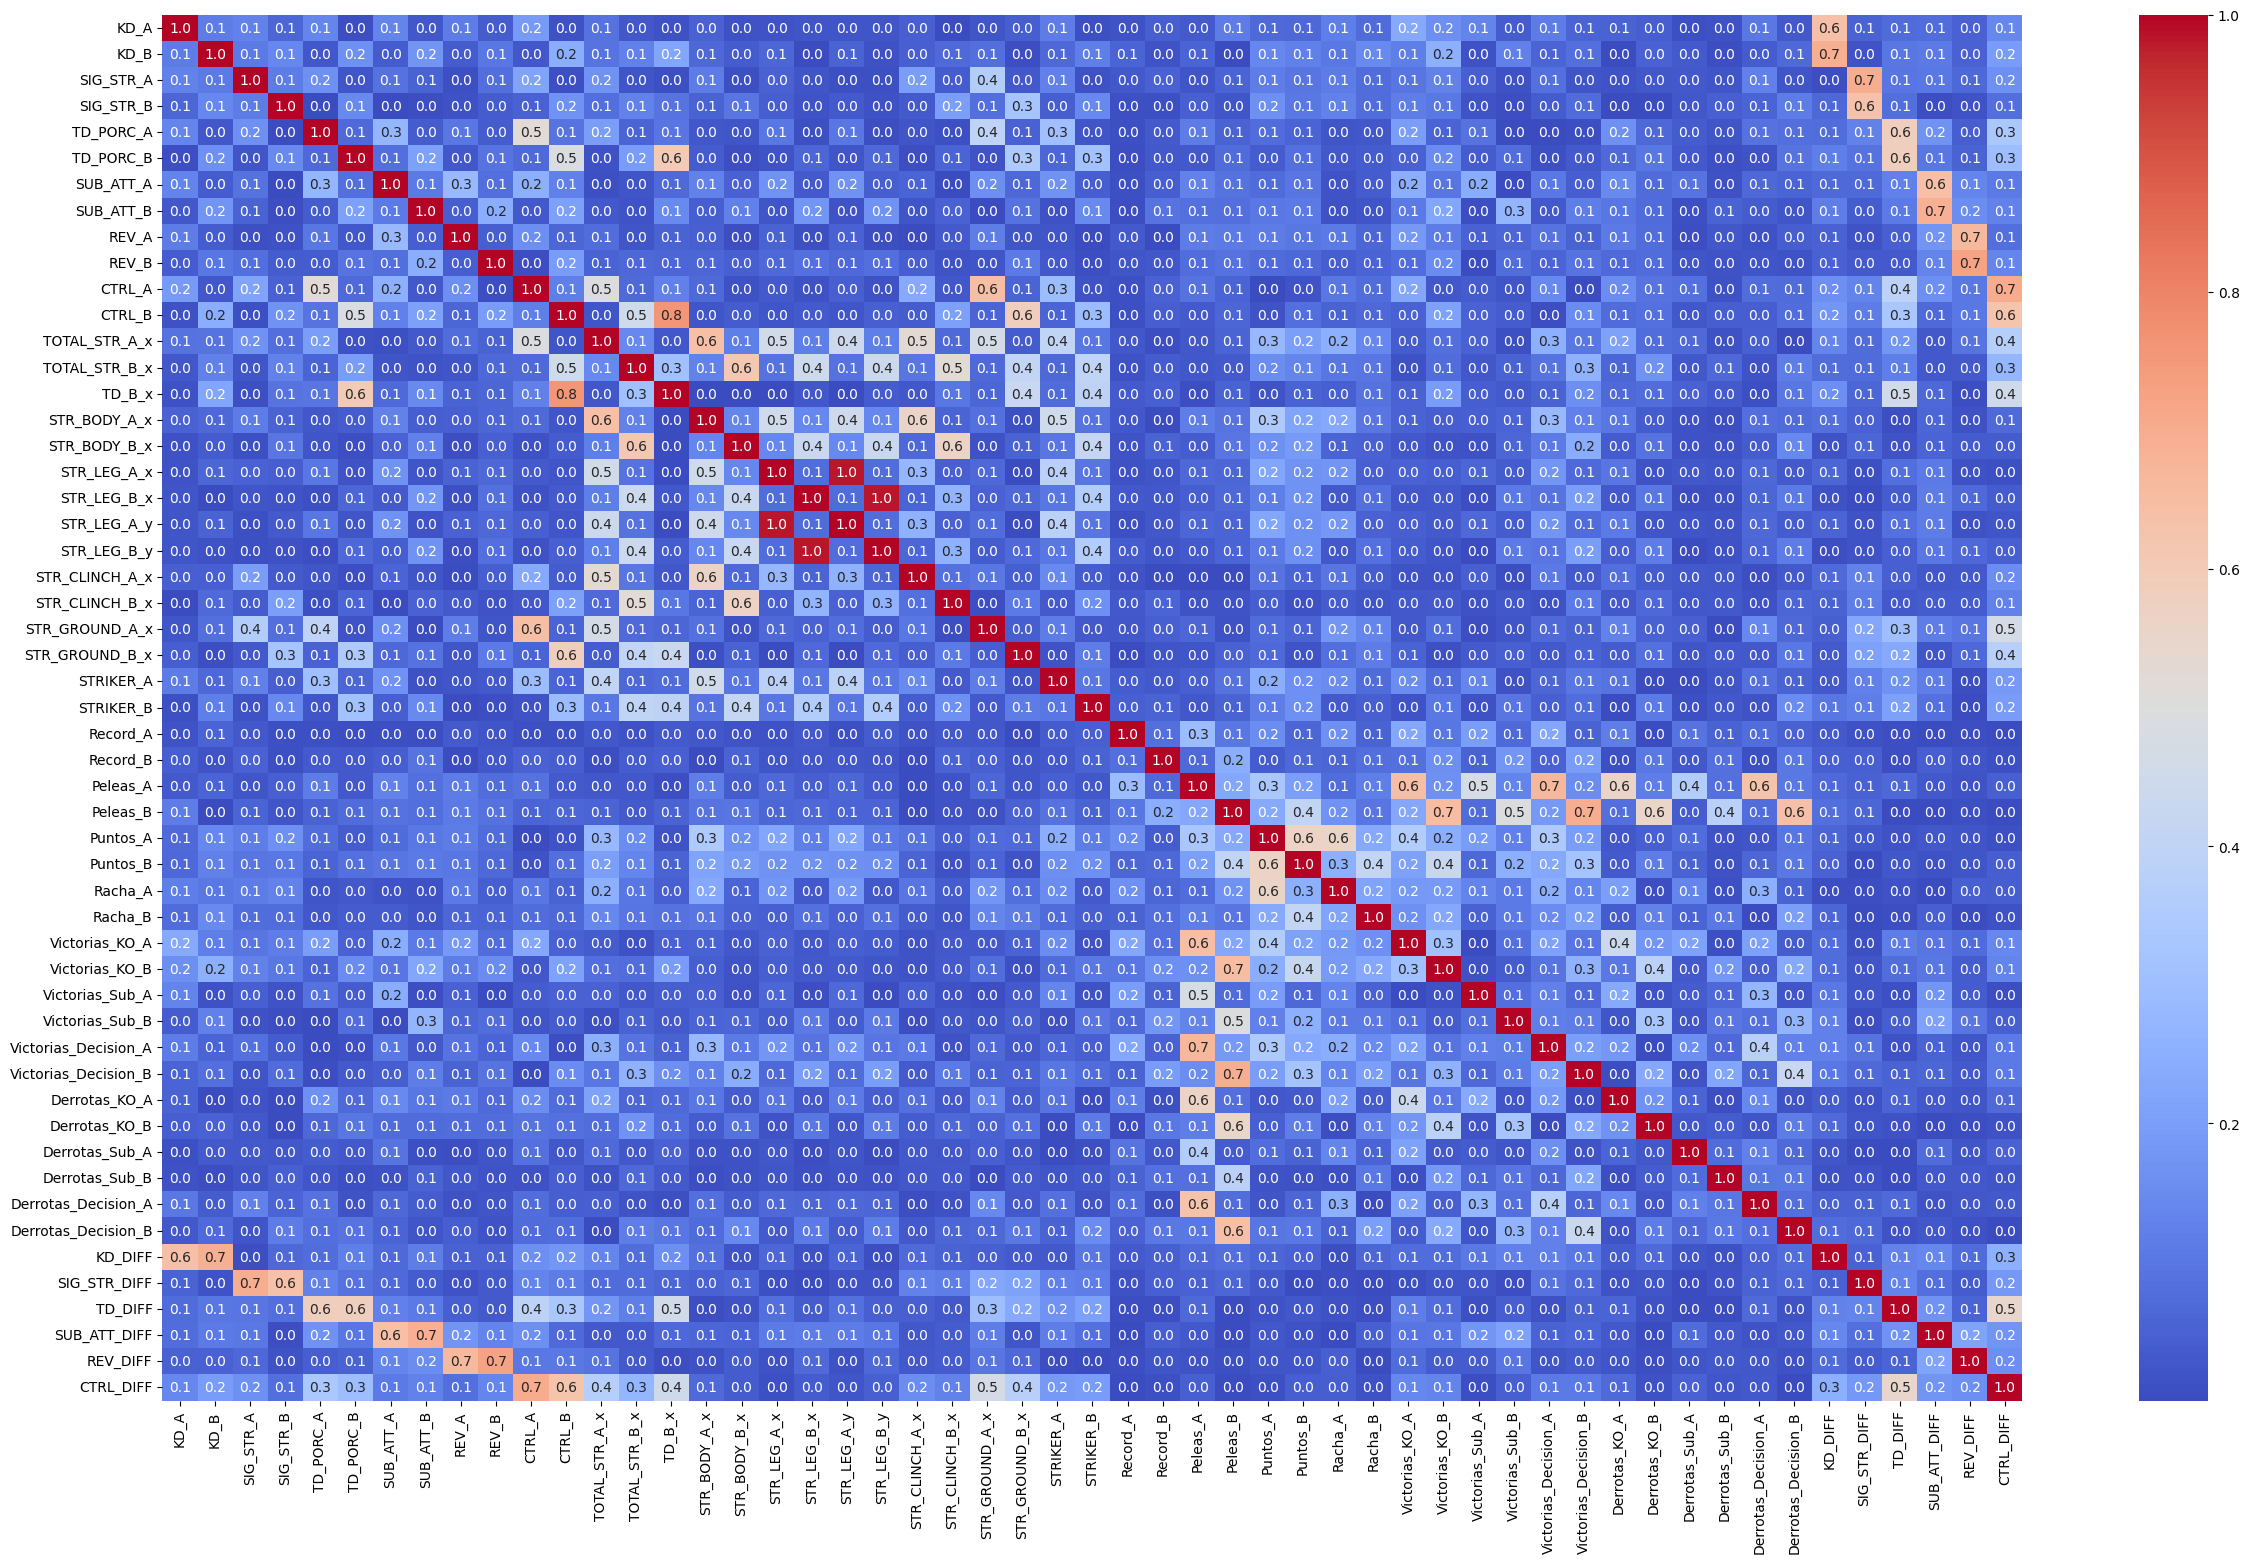

In [17]:
plt.figure(figsize=(30, 18))
sns.heatmap(X_train.corr().abs(), annot=True, cmap="coolwarm", fmt=".1f")
plt.show()

In [25]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [26]:
# Crear el modelo con pesos balanceados
model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)

# Entrenar el modelo
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [27]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

In [28]:
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

Matriz de Confusión:
[[ 83 205]
 [ 36 198]]

Reporte de Clasificación:
              precision    recall  f1-score   support

       False       0.70      0.29      0.41       288
        True       0.49      0.85      0.62       234

    accuracy                           0.54       522
   macro avg       0.59      0.57      0.51       522
weighted avg       0.61      0.54      0.50       522



In [29]:
y_prob = model.predict_proba(X_test)[:, 1]  # Probabilidad de que gane el Peleador_B
best_threshold = 0.5
best_f1 = 0

for threshold in np.arange(0.3, 0.7, 0.05):  # Probar diferentes umbrales
    y_pred_adj = (y_prob >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_adj)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Mejor umbral encontrado: {best_threshold} con F1-score de {best_f1:.4f}")

# Aplicar el mejor umbral
y_pred = (y_prob >= best_threshold).astype(int)


Mejor umbral encontrado: 0.44999999999999996 con F1-score de 0.6314


In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.75      0.19      0.31       288
        True       0.48      0.92      0.63       234

    accuracy                           0.52       522
   macro avg       0.61      0.56      0.47       522
weighted avg       0.63      0.52      0.45       522



In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from scipy.stats import loguniform

# Modelo base
model = LogisticRegression(
    random_state=42,
    max_iter=1000,  # Reducimos iteraciones para acelerar
    solver='saga'   # 'saga' soporta tanto L1 como L2 y es eficiente en grandes datasets
)

# Espacio de búsqueda reducido
param_dist = {
    'logisticregression__C': loguniform(0.001, 10),  # Búsqueda en escala logarítmica
    'logisticregression__penalty': ['l1', 'l2'],  # L1 y L2
}

# Pipeline sin características polinomiales para acelerar
pipeline = make_pipeline(
    PolynomialFeatures(degree=1),  # Eliminamos interacciones cuadráticas para mayor velocidad
    model
)

# RandomizedSearch en vez de GridSearch para probar menos combinaciones
random_search = RandomizedSearchCV(
    pipeline, param_distributions=param_dist, 
    n_iter=20,  # Solo 20 combinaciones aleatorias en vez de todas
    cv=3,  # Validación cruzada con 3 pliegues en vez de 5
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

# Ajustar el modelo
random_search.fit(X_train, y_train)

# Mejor modelo encontrado
best_model = random_search.best_estimator_
print(f"Mejor modelo: {random_search.best_params_}")

# Evaluar el modelo en test
y_pred = best_model.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix

print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejor modelo: {'logisticregression__C': np.float64(5.634019968066191), 'logisticregression__penalty': 'l1'}
Matriz de Confusión:
[[162 126]
 [ 95 139]]

Reporte de Clasificación:
              precision    recall  f1-score   support

       False       0.63      0.56      0.59       288
        True       0.52      0.59      0.56       234

    accuracy                           0.58       522
   macro avg       0.58      0.58      0.58       522
weighted avg       0.58      0.58      0.58       522



In [38]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Predicciones en el conjunto de test
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]  # Probabilidades para el umbral

# Imprimir la matriz de confusión
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

# Imprimir el reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Calcular la AUC (Area Under Curve)
roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nAUC: {roc_auc:.4f}")


Matriz de Confusión:
[[162 126]
 [ 95 139]]

Reporte de Clasificación:
              precision    recall  f1-score   support

       False       0.63      0.56      0.59       288
        True       0.52      0.59      0.56       234

    accuracy                           0.58       522
   macro avg       0.58      0.58      0.58       522
weighted avg       0.58      0.58      0.58       522


AUC: 0.6297


In [39]:
import numpy as np
from sklearn.metrics import f1_score

# Probar diferentes umbrales
best_threshold = 0.5
best_f1 = 0

for threshold in np.arange(0.3, 0.7, 0.05):  # Probar umbrales entre 0.3 y 0.7
    y_pred_adj = (y_prob >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred_adj)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Mejor umbral: {best_threshold} con F1-score de {best_f1:.4f}")

# Aplicar el mejor umbral
y_pred = (y_prob >= best_threshold).astype(int)


Mejor umbral: 0.35 con F1-score de 0.6303


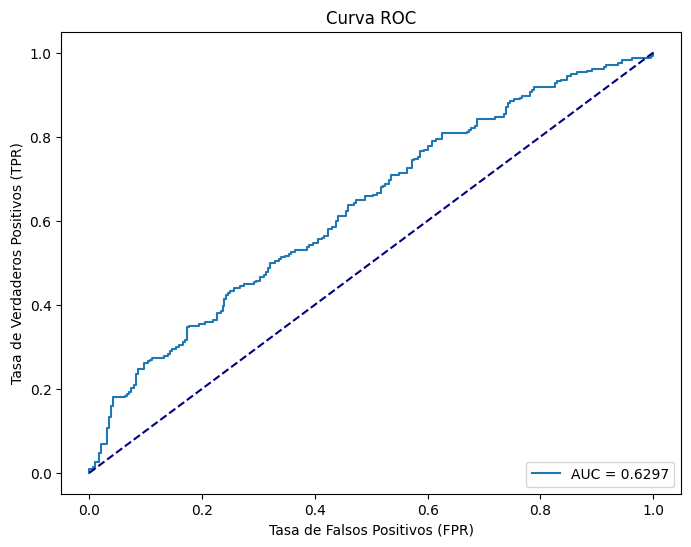

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()
